# Plot Time Series of Raw Data

Examples of annual plots, point data extraction, and time series plots generated using the `nisar.VelocitySeries()` data.

---

### 1. Load packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

### 2. Grab ZI time series data and flowline data

In [2]:
ziVelSeries = nisar.nisarVelSeries()
ziVelSeries.readSeriesFromNetCDF('../data/raw/ZachariaeIsstromVelocitySeries.nc')

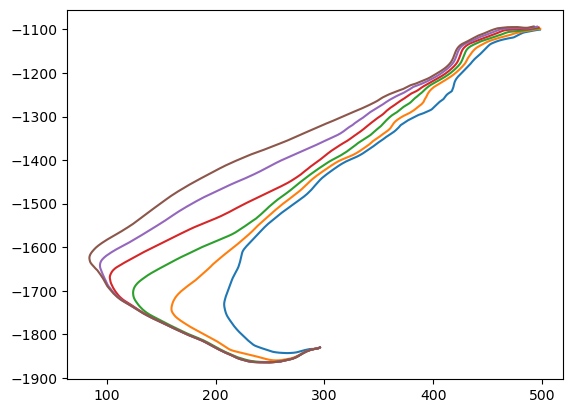

In [ ]:
# Convert the flowline data from m to km
ziFlowlines['geometry_km'] = ziFlowlines['geometry'].apply(lambda geom: geom.xy)
ziFlowlines['geometry_km'] = ziFlowlines['geometry_km'].apply(lambda xy: (np.array(xy[0]) / 1000, np.array(xy[1]) / 1000))

# Plot the flowlines
for flowline_km in ziFlowlines['geometry_km']:
    plt.plot(flowline_km[0], flowline_km[1])

### 3. Plot first annual velocity maps
Plot the annual velocity series' first timestep values with flowlines on top. Notice that the data for 2015 are not perfect as this was the first Sentinel-1 acquisition year.

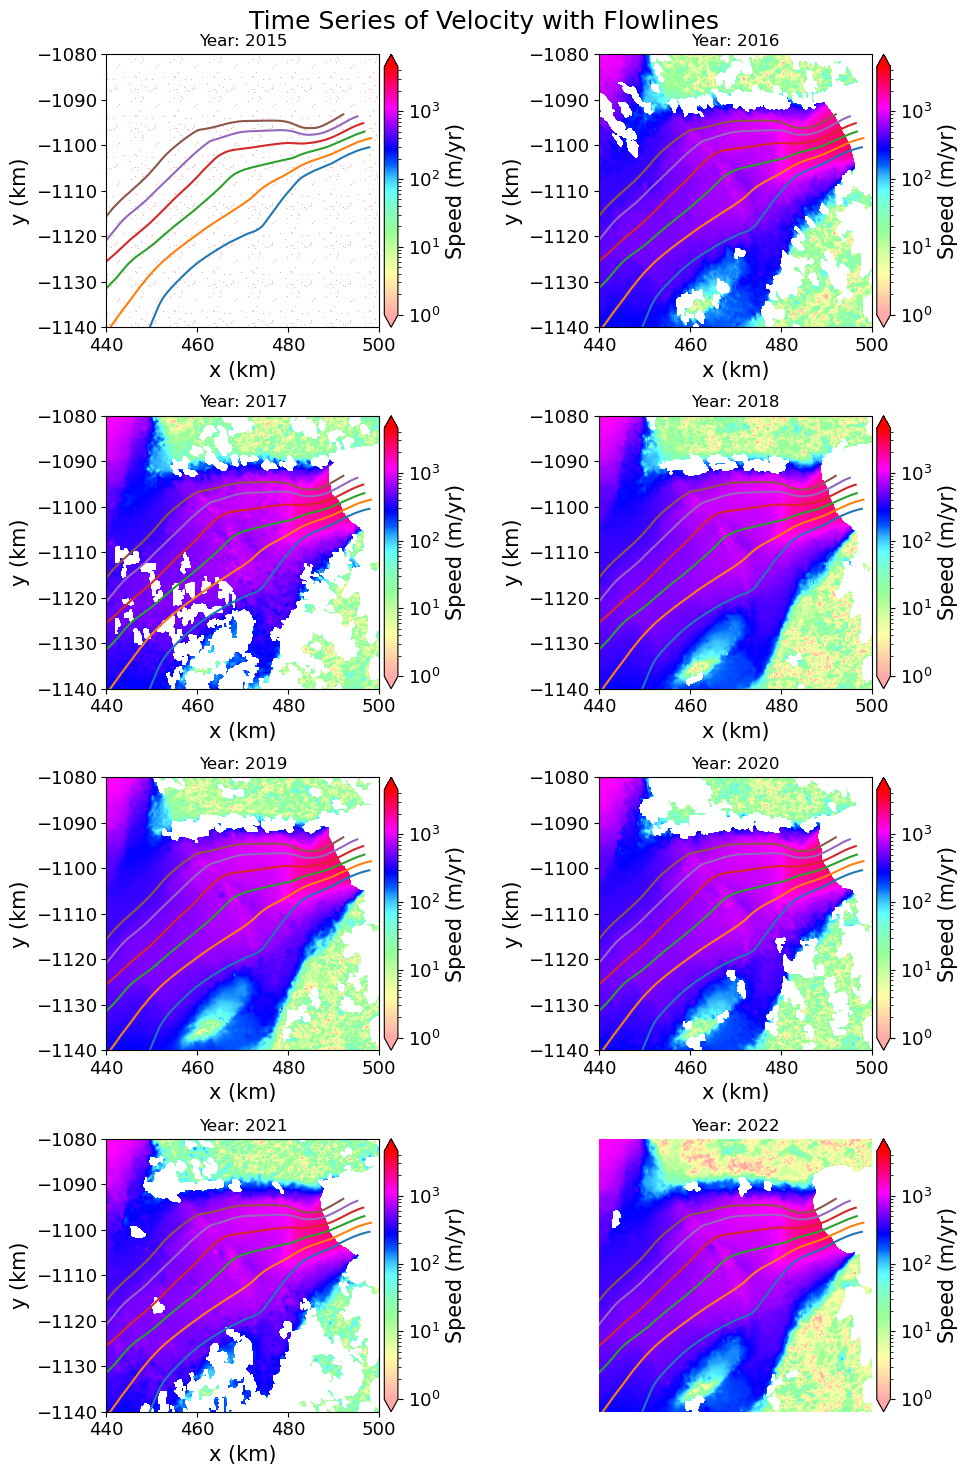

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

# Convert myVelSeries.time to a pandas Series to extract the year
time_series = pd.Series(ziVelSeries.time)
years = time_series.dt.year.unique()

for ax, year in zip(axes.flatten(), years):
    dates_in_year = time_series[time_series.dt.year == year]
    if not dates_in_year.empty:
        ziVelSeries.displayVelForDate(date=dates_in_year.iloc[0], ax=ax, autoScale=False, vmin=1, vmax=4500, units='km', axisOff=False, scale='log')
        ax.set_title(f'Year: {year}')
        for flowline_km in ziFlowlines.geometry_km:
            ax.plot(flowline_km[0], flowline_km[1])
    axes[-1, -1].axis('off')  # remove any empty axes if odd number of years

    ax.set_xlim(ziVelSeries.extent()[0]/1000, ziVelSeries.extent()[1]/1000)
    ax.set_ylim(ziVelSeries.extent()[2]/1000, ziVelSeries.extent()[3]/1000)
fig.suptitle('Time Series of Velocity with Flowlines', fontsize=18)
fig.tight_layout()

### 4. Grab ZI time series data and define points

In [12]:
xpts, ypts = [457794.675537/1000, 475697.184021/1000, 488900.158671/1000], [-1107613.706862/1000, -1101544.002803/1000, -1098954.829477/1000]
colors = ['r', 'orange', 'b']
symbols = ['*', '^', 'o']
labels = ['Upstream', 'Middle', 'Near terminus']

Plot one velocity image and the points.

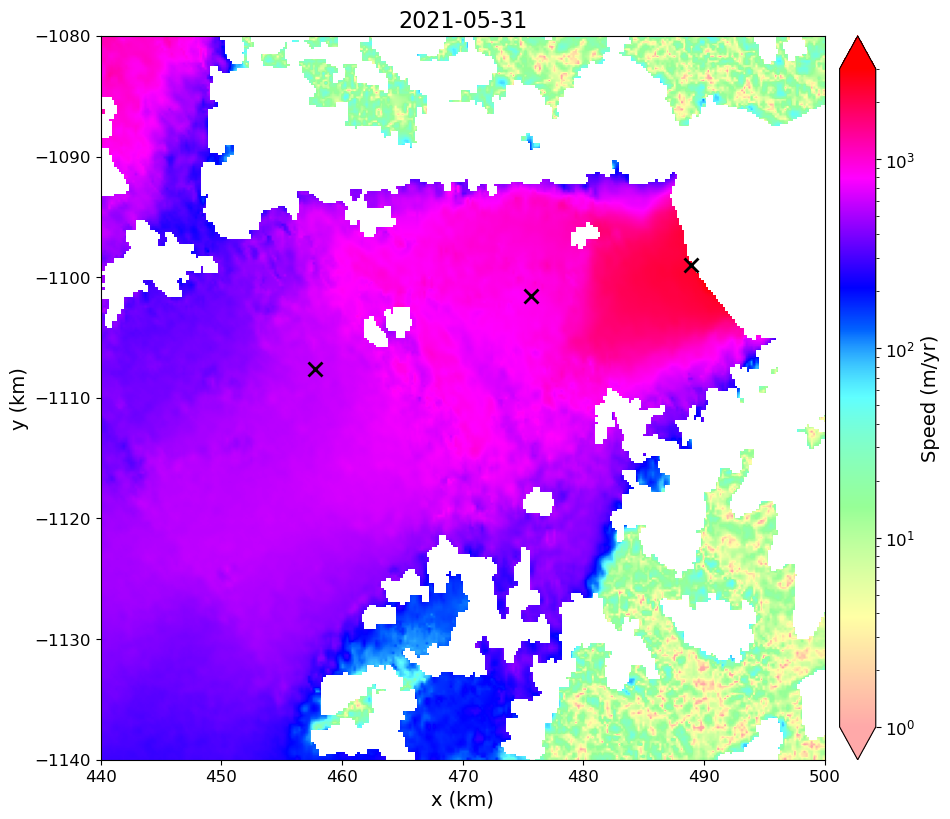

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ziVelSeries.displayVelForDate(date='2021-06-01',labelFontSize=14, plotFontSize=12, titleFontSize=16, 
                              vmin=1, vmax=3000, scale='log',colorBarPad=0.15, units='km', axisOff=False, ax=ax)
ax.plot(xpts, ypts, 'kx', markersize=10, markeredgewidth=2)

### 5. Plot the time series with the mean velocity

Some values in 2015 are zero because there is no velocity data at that point during 2015 due to the launch date.

In [14]:
velMean = ziVelSeries.mean()

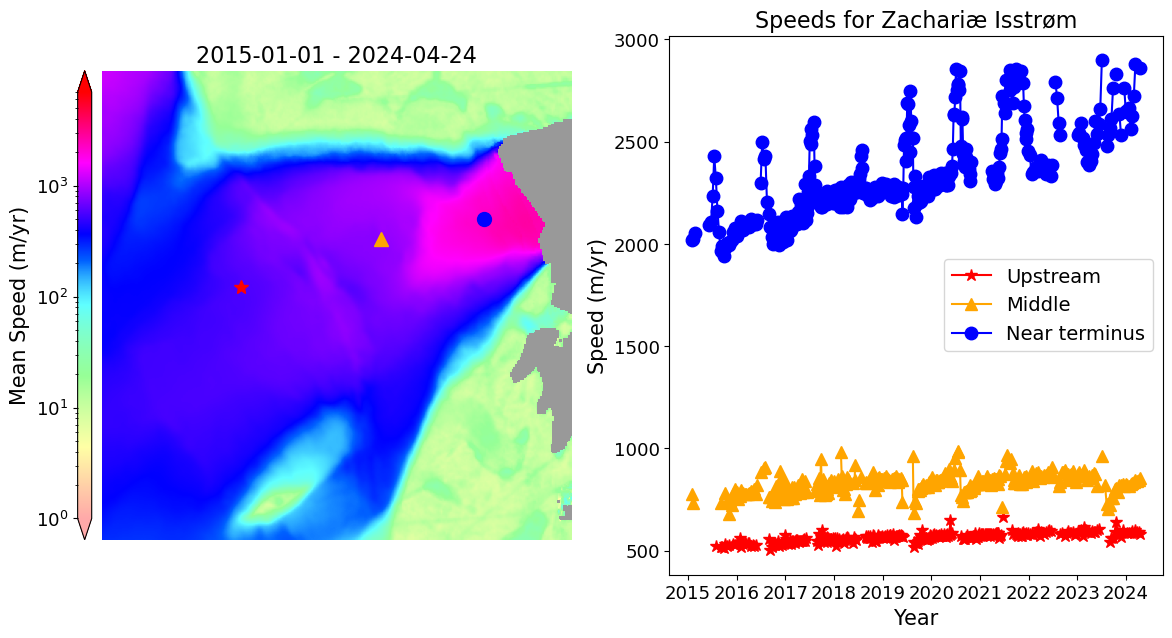

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
mapAxes, plotAxes = axes
# Map plot
velMean.displayVelForDate(ax=mapAxes, units='km', autoScale=True, axisOff=True, scale='log',
                                 midDate=False, colorBarLabel='Mean Speed (m/yr)', 
                                 extend='both', backgroundColor=(0.6, 0.6, 0.6), colorBarPosition='left', vmin=1, colorBarSize='3%', colorBarPad=.1)
# Loop to plot points
for x, y, symbol, color, label in zip(xpts, ypts, symbols, colors, labels):
    # plot points on map
    mapAxes.plot(x, y, symbol, color=color, markersize=10) 
    # plot values only if they are not 0 or null
    ziVelSeries.plotPoint(x, y, ax=plotAxes, band='vv',  marker=symbol, color=color,  linestyle='-',
                        units='km', label=label, markersize=9)
# Finish plots
ziVelSeries.labelPointPlot(xLabel='Year', yLabel='Speed (m/yr)', ax=plotAxes, title='Speeds for Zachariæ Isstrøm')
plotAxes.legend(fontsize=14)